In [1]:
import json
import pprint
import numpy as np
from joblib import Parallel, delayed
import pandas as pd
from thumos14_helper import Thumos14
from utils import segment_format
from utils import segment_iou
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(9.5, 4), dpi=100)
%matplotlib inline

/usr/lib64/python2.7/site-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 7 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


In [2]:
th14 = Thumos14('../data/thumos14/')
df = th14.segments_info('test')

In [3]:
def plot_recall_vs_n_proposals(proposal_df, df, iou_thr=np.arange(0.5, 1.05, .05), pcns=np.arange(1, 101), 
                               return_var=False):
    vds = proposal_df['video-name'].unique()
    score_lst = []
    # Compute iou score
    for v in vds:
        # Proposals
        idx = proposal_df['video-name'] == v
        this_df = proposal_df.loc[idx]
        proposals = np.stack((this_df['f-init'], 
                              this_df['f-end']), axis=-1)
        
        # Sort proposals
        idx = this_df['score'].argsort()[::-1]
        proposals = proposals[idx, :]
        
        # Annotations
        jdx = df['video-name'] == v
        ann_df = df.loc[jdx]
        annotations = np.stack((ann_df['f-init'],
                                ann_df['n-frames']), axis=-1)
        annotations = segment_format(annotations, 'd2b')
        score_lst.append(segment_iou(annotations, proposals))
    matches = np.empty((vds.shape[0], pcns.shape[0]))
    pos = np.empty(vds.shape[0])
    # Matching
    recall = np.empty((iou_thr.shape[0], pcns.shape[0]))
    for cidx, this_iou in enumerate(iou_thr):
        for i, sc in enumerate(score_lst):
            pos[i] = sc.shape[0]
            for j, pcn in enumerate(pcns):
                this_pcn = pcn / 100.0
                lmt = int(sc.shape[1]*this_pcn)
                matches[i, j] = ((sc[:, :lmt] >= this_iou).sum(axis=1) > 0).sum()
        this_recall = matches.sum(axis=0) / pos.sum()
        recall[cidx, :] = this_recall
    pp = (proposal_df.shape[0]*1.0) / vds.shape[0]
    if return_var:
        return pcns, recall.mean(axis=0), pp
    else:
        print 'Average # of proposals per video: {}'.format(pp)
        plt.plot(pcns, recall.mean(axis=0), linewidth=3)

LSTM Evaluation
-------------------
Recall analysis on Thumos14 testing set.
The evaluation includes results for both including model localization and excluding model localization.

* When localization is excluded, we only use the score predicted by the model for each prior.
* When localization is included, we change the prior locations.

Parameters: -lr 1e-4 -a 0.1 -w 512 -d 1 -m lstm -ne 150 -sf 40 -ds concat-16-mean-3d -s 120 -g 3

Experiment: Localize-128
{u'T': 256,
 u'dataset': u'thumos14-test',
 u'filter': None,
 u'nms': True,
 u'priors_filename': None,
 u'stride': 128}
Average # of proposals per video: 454.629107981


Experiment: Non-localize-128
{u'T': 256,
 u'dataset': u'thumos14-test',
 u'filter': None,
 u'nms': True,
 u'priors_filename': u'/home/escorciav/projects/dapg/data/experiments/thumos14/a02/train_priors.hkl',
 u'stride': 128}
Average # of proposals per video: 576.892018779


Experiment: Localize-64
{u'T': 256,
 u'dataset': u'thumos14-test',
 u'filter': None,
 u'nms': True,
 u'priors_filename': None,
 u'stride': 64}
Average # of proposals per video: 701.41314554


Experiment: Non-localize-64
{u'T': 256,
 u'dataset': u'thumos14-test',
 u'filter': None,
 u'nms': True,
 u'priors_filename': u'/home/escorciav/projects/dapg/data/experiments/thumos14/a02/train_priors.hkl',
 u'stride': 64}
Average # of proposals per video: 897.896713615




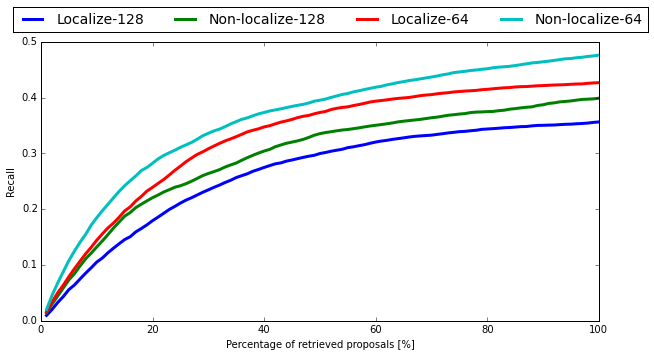

In [4]:
plt.figure(num=None, figsize=(10, 5), dpi=100)
EXP_ID = ['01', '02', '03', '04']
LEGENDS = {'01': 'Localize-128', '02': 'Non-localize-128', '03': 'Localize-64', '04': 'Non-localize-64'}
for eid in EXP_ID:
    proposal_df = pd.read_csv('../data/experiments/thumos14/a02/000/eval/{}/result.proposals'.format(eid), 
                              sep=' ')
    with open('../data/experiments/thumos14/a02/000/eval/{}/config.json'.format(eid), 'r') as fobj:
        print 'Experiment: {}'.format(LEGENDS[eid])
        pprint.pprint(json.load(fobj))
    plot_recall_vs_n_proposals(proposal_df, df)
    print '\n'
plt.legend([LEGENDS[x] for x in EXP_ID], ncol=len(EXP_ID), bbox_to_anchor=[1.1, 1.15], prop={'size':14})
plt.ylabel('Recall')
plt.xlabel('Percentage of retrieved proposals [%]')
plt.show()

State-of-the-art Comparison
---------------------------------
This make an apple to apple comparison against state-of-the-art methods:
* Caba et al. 2016.
* ATP BMVC 2015.

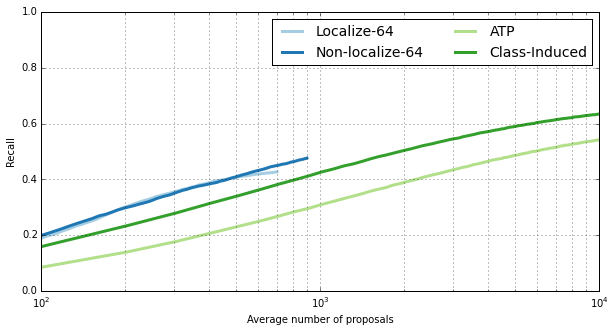

In [5]:
# Load state-of-the-art results
with open('../data/state-of-the-art/atp.thumos14.pcns.json') as fobj:
    atp_data = json.load(fobj)
with open('../data/state-of-the-art/supervised.thumos14.pcns.json') as fobj:
    class_induced_data = json.load(fobj)

# Same style.
BREWCOLORS_CATEGORICAL = np.array([(166,206,227),
                                   (31,120,180),
                                   (178,223,138),
                                   (51,160,44),
                                   (251,154,153),
                                   (227,26,28)])/255.0
colors = {"Class-Induced": BREWCOLORS_CATEGORICAL[3],
          "ATP": BREWCOLORS_CATEGORICAL[2],
          "Non-localize-64": BREWCOLORS_CATEGORICAL[1],
          "Localize-64": BREWCOLORS_CATEGORICAL[0],
          "Non-localize-128": BREWCOLORS_CATEGORICAL[5],
          "Localize-128": BREWCOLORS_CATEGORICAL[4]}
    
# Compute data
plt.figure(num=None, figsize=(10, 5), dpi=100)
EXP_ID = ['03', '04']
LEGENDS = {'03': 'Localize-64', '04': 'Non-localize-64'}
for eid in EXP_ID:
    proposal_df = pd.read_csv('../data/experiments/thumos14/a02/000/eval/{}/result.proposals'.format(eid), 
                              sep=' ')
    pcns, recall, nprop = plot_recall_vs_n_proposals(proposal_df, df, return_var=True)
    plt.semilogx(pcns/100.0*nprop, recall, linewidth=3, color=colors[LEGENDS[eid]])
plt.semilogx(np.array(atp_data['pcns'])*atp_data['nr_proposals'], atp_data['recall'], 
             linewidth=3, color=colors['ATP'])
plt.semilogx(np.array(class_induced_data['pcns'])*class_induced_data['nr_proposals'], 
             class_induced_data['recall'], linewidth=3, color=colors['Class-Induced'])

plt.legend([LEGENDS[x] for x in EXP_ID] + ['ATP', 'Class-Induced'], ncol=2, prop={'size':14})
plt.ylabel('Recall')
plt.xlabel('Average number of proposals')
plt.grid(b=True, which="both")
plt.ylim([0,1])
plt.xlim([10**2, 10**4])
plt.show()

Comparison to uniformly scoring at random
--------------------------------------------------

Average # of proposals per video: 897.896713615


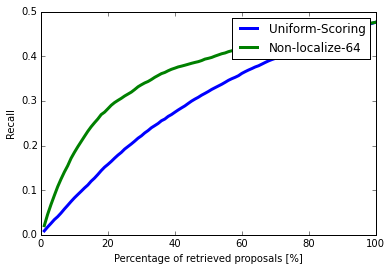

In [7]:
#########################################################
# Uniformly at random proposal scoring.
#########################################################
def random_scoring(proposal_df):
    """Overwrites existing score for video proposals with 
    scores generated uniformly at random.
    """
    vds = proposal_df['video-name'].unique()
    new_df = []
    for v in vds:
        idx = proposal_df['video-name'] == v
        this_df = proposal_df.loc[idx].copy()
        unf_score = np.random.uniform(0, 1, this_df.shape[0])
        this_df['score'] = unf_score
        new_df.append(this_df)
    return pd.concat(new_df, axis=0)

def wrapper_random_scoring(proposal_df):
    new_proposal_df = random_scoring(proposal_df)
    pcn, recall, _ = plot_recall_vs_n_proposals(new_proposal_df, df, pcns=pcns, return_var=True)
    return recall

f = '../data/experiments/thumos14/a02/000/eval/04/result.proposals'
proposal_df = pd.read_csv(f, sep=' ')
nreps = 50
pcns = np.arange(1, 101)
rnd_recall = Parallel(n_jobs=24)(delayed(wrapper_random_scoring)(proposal_df) for i in range(nreps))
rnd_recall = np.array(rnd_recall)

plt.plot(pcns, rnd_recall.mean(axis=0), linewidth=3)
plot_recall_vs_n_proposals(proposal_df, df)
plt.legend(['Uniform-Scoring', 'Non-localize-64'])
plt.ylabel('Recall')
plt.xlabel('Percentage of retrieved proposals [%]')
plt.show()